# Toy Model - Gut-Brain Axis in Reinforcement Behavior

We start with defining the Behavior/Action Module.

Essentially, Behavior -> Gut Bacteria -> Reinforcement in Brain -> Behavior.

Let's define one object for each of the compartments here - Behavior, Gut, Brain.

## Behavior

This module computes a State Transition Matrix upon instantiation.
When you create a Behavior object, it will take some time because the STM takes time to compute.
But it enables fast running of the actual simulation because the pre-computed matrix is directly
used.



## Gut

__Attributes:__

- agentArray[] OR populationSizeArray[]
- output                      #eg: dopamine

__Methods:__

- updateAgents() OR updatePopulations()
- getOutput()



## Brain

__Attributes:__

- alpha
- gamma
- epsilon
- qTable
- currentActionIndex


__Methods:__

- explore()
- exploit()
- computeReward(Gut.output)
- learn() 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import random

In [8]:
# random.seed(1)

# class Bacteria():
    
    
    
class Behavior():    
    def __init__(self, initState):
        
        """
        CLASS BEHAVIOR
        This is where actions are implemented to change the state of the system.
        
        
        INPUTS:
        
        initState -> The initial state of the system.
                     Under current implementation an n-tuple of floats.
                     Float values must be b/w 0.0 and 1.0 in intervals of 0.1.
                     eg: (1.0, 0.2, 1.0) 
                   
                   
        ATTRIBUTES:
 
                        
        stateSet ->     A list of all possible states, ie a list of n-tuples.
        
        actionSet ->    A list of actions. 
                        The format is dependant on how you define an action.
                        But as a general rule, use the index and not the values when interacting
                        with the RL module.
                        Use the values only in the applyAction() method.
                        
        output ->       Binary triplet. Sampled independantly, where each stateSet value is
                        interpreted as a probability of the corresponding nutrient output
                        being 1.
        """

        self.stateSet = list(product(np.linspace(0,1,11).round(1),np.linspace(0,1,11).round(1),np.linspace(0,1,11).round(1)))
        self.actionSet = list(product(np.linspace(-0.1,0.1,2),np.linspace(-0.1,0.1,2),np.linspace(-0.1,0.1,2)))
       
        #(+0.1, +0.1, -0.1)
        
        ## Checking if user initialized constructor with a valid state 
        self.validInitState = False 
        for state in self.stateSet:
            
            # Turn true only if the entered state matches one of the possible states
            if(state == initState):
                self.validInitState = True
        
        if(self.validInitState):
            self.initState = list(initState)
        else:
            # If user enters an invalid state, take a state at random instead
            self.initState = list(random.choice(self.stateSet))     
        ## Fin
        
        self.newState = [0, 0, 0]   #Initializing
        self.stateTransitionMatrix = np.zeros((len(self.stateSet), len(self.actionSet)))
        
        self.output = [0, 0, 0]
        self.computeStateTransitions()
        
    def computeStateTransitions(self):
        """
        This method computes and stores the State Transition Matrix
        The STM is a matrix with S rows and A columns where S is number of possible
        states, and A is number of possible actions.
        
        Any value in the matrix ie STM(i, j) = index of the state we will go to when we take
        action j when the system's current state is i.
        """
        
        #for each state, for each action
        for s in range(len(self.stateSet)):
            for a in range(len(self.actionSet)):
                # perform action (eg: state + action) to get values of newState
                self.applyActionToState(a, s)
                
                # now find the index of the state with which the newState variables match.
                for ind, st in enumerate (self.stateSet):
                    if(round(self.newState[0], 1) == round(st[0], 1) and
                       round(self.newState[1], 1) == round(st[1], 1) and
                       round(self.newState[2], 1) == round(st[2], 1)):
                        self.stateTransitionMatrix[s, a] = int(ind)
                        
#                         print("==================We get ", self.stateSet[ind], "=================")
        
            
            print("States computed ", s + 1, "/",  len(self.stateSet))
   

    def applyActionToState(self, actionIndex, stateIndex):
        """
        To change the implementation of actions, change only the below code and/or 
        the actionSet definition
        
        This is to be called only in the computeStateTransition() function.
        """

#         print("Applying ", self.actionSet[actionIndex], " to ", self.stateSet[stateIndex])

        for i in range(len(self.initState)): 
            # Clipping state values to between 0 and 1
            if((np.round(self.stateSet[stateIndex][i], 1) + 
               np.round(self.actionSet[actionIndex][i], 1)) >= 0 and
               (np.round(self.stateSet[stateIndex][i], 1) +
               np.round(self.actionSet[actionIndex][i], 1)) <= 1):
                self.newState[i] = self.stateSet[stateIndex][i] + self.actionSet[actionIndex][i]
            else:
                self.newState[i] = self.stateSet[stateIndex][i] 
                
        self.newState[i] = np.round(self.newState[i], 1)

                
#         print("We May Get ", self.newState)

            
#     def updateStateWithAction(self, ):
#         """ 
#         This is to be used whenever you need to update a state in the future
#         """
#         self.currentState = self.newState

               
        
        
    def generateBehavioralOutput(self, stateIndex):
        """
        This function Maps the state to the behavioral output
        """
        for i in range(len(self.output)):
            self.output[i] = np.random.binomial(1, self.stateSet[stateIndex][i])
        

In [97]:

class Gut:
    def __init__(self, *args):
        """
        Currently (05/03/21), there are 2 implementations of the Gut module.
        
        In the first one, an inputWeightMatrix linearly combines nutrient input with bacterial
        preferences, and gives an output value for each bacterial species which can be summed.
        The relevent method for this implementation is mapNutrientsToDopamine().
        
        In the second implementation, a species grows in the presence of its relevant nutrient
        with first order growth kinetics. It also decays with first order kinetics at every time
        step. What could possibly stabilise this system?
        
        You can enter either a single argument or more to this constructor.
        
        
        INPUTS:
        1. inputWeightMatrix (Mandatory) -> (b x n) matrix, where b is number of bacterial species and 
                                            n is number of nutrients.
                                            The weights are linearly combined with state values from
                                            Behavior to get output (dopamine) levels.
                                            This is for the simplistic implementation, without
                                            considering populations
        2,3,... are initial populations for the various bacterial species.
        
        
        ATTRIBUTES
        
        growthConstant: float value. It is the proportion increase in the populations after
                        one unit of nutrient has been received.
        decayConstant:  float value. 
        
        """
        # Assign first argument to the weight matrix
        self.bacteriaWeightMatrix = args[0] 

        # Now add the remaining arguments to initial population values
        if(len(args) > 1):
            self.populations = [args[i + 1] for i in range(len(args) - 1)]
        else:
            # Set default values, if the user gives only the weight matrix argument
            self.populations = np.array([100, 100, 100], dtype = np.uint64)
            
        self.output = 0
        
        self.growthConstant = 0.1
        self.decayConstant = 0.1
        
        # Which population contributes dopamine by how much
        self.populationContributionsToDopamine = np.array([ 1, 0, 0 ])
        
        # How do the populations depend on each other
        self.populationInterdependancyMatrix = []
        
        # What's the max total population before reward signal/dopamine starts decreasing
        # Non-positive value means no limit
        self.populationLimit = 10000

    ## Population-free Implementation.
    def mapNutrientsToDopamine(self, inputNutrients): 
        """
        input -> (n x 1) array of nutrient quantities
        Bacteria linearly combines nutrient inputs to produce dopamine.
        Use this if you want a non-population based, very simplistic implementation of reward.
        """
        self.output = np.sum(self.bacteriaWeightMatrix * inputNutrients)        
        
    
    ## Population-based implementation
    def mapNutrientsToPopulations(self, inputNutrients):
        """
        input -> (n x 1) array of nutrient quantities
        """
        for i in range(len(self.populations)):
            # Growing the population as per first order growth when nutrients are available 
            self.populations[i] = self.populations[i] + self.populations[i]*inputNutrients[i]*self.growthConstant
            # Decaying populations as per first order decay at every time step
            self.populations[i] = self.populations[i] - self.populations[i]*self.decayConstant
#         print(self.populations)

    def mapPopulationsToDopamine(self):
        self.output = np.sum(self.populations*self.populationContributionsToDopamine)
        


    def penaliseHighPopulation(self):
        # Using y = -x^2 function, and translating it so that it goes through (0, 0) and peaks at
        # the population limit on positive x-axis
        
        self.output = - (self.output - self.populationLimit)**2 + self.populationLimit**2
#         print("Reward is, ", self.output)
    
    def applyInterdependancies(self):
        """
        The populationInterdependancyMatrix has rows n x n, where an element i x j is the 
        signed weight of how much the population of species i depends on that of species j.
        """
        
        for i in range(len(self.populations)):
            for j in range(len(self.populations)):
                self.populations[i] = self.populations[i] 
                + self.populationInterdependencyMatrix[i, j]*self.populations[j]

class Brain:
    def __init__(self, behavior, **kwargs):

        # Params
        self.alpha = kwargs.get('alpha', 0.05)
        self.gamma = kwargs.get('gamma', 0.05)
        self.epsilon = kwargs.get('epsilon', 0.05)

        # Inputs
        self.stateTransitionMatrix = behavior.stateTransitionMatrix
        self.stateSet = behavior.stateSet
        self.actionSet = behavior.actionSet
        
        # To be computed
        self.qTable = np.zeros((len(self.stateSet), len(self.actionSet)))
        self.oldStateIndex = 0
        self.oldActionIndex = 0
        self.currentActionIndex = 0
        self.maxFutureQ = 0
        self.theReward = 0
        self.currentStateIndex = int(0)

     
        
    def computeReward(self, gutOutput):
        """
        Maps gut output to the RL reward
        """
        self.theReward = gutOutput
              
            

        
    def learnAndAct(self):
        """
            This method updates the Q-Table.
            It also controls the state transitions.
            To get state/action history, we should get the currentStateIndex, currentActionIndex
            but be careful of at what stage we are getting them.
        """
        #First store the just implemented state and action as old state and action.
        
        self.oldStateIndex = self.currentStateIndex
        self.oldActionIndex = self.currentActionIndex
        
        # Then use the existing QTable to choose the best action.
        
        if(random.random() > self.epsilon):
            self.exploit()
        else:
            self.explore()

        # Now we have a new value stored for currentActionIndex.
        # thereafter, we use behavior.stateTransitionMatrix to look up the next state
        
        self.currentStateIndex = int(behavior.stateTransitionMatrix[self.oldStateIndex,
                                                                self.oldActionIndex])
            
        # For the new state, compute best possible action value.
        self.maxFutureQ = max(self.qTable[self.currentStateIndex, :])

        # Update the QTable
        self.qTable[self.oldStateIndex, self.oldActionIndex] = self.qTable[self.oldStateIndex, self.oldActionIndex] + self.alpha*(self.theReward + self.gamma*self.maxFutureQ - self.qTable[self.oldStateIndex, self.oldActionIndex])
        
        
        
        
        
        
           
    def exploit(self):
        
        """ 
            Of all the actions in the current state pick the one with maximum Q-value.
            If there is a tie, pick one of the winners at random.
            
            # self.currentActionIndex = random.choice(np.where(qTable[currentStateIndex, :] ==
            #                                      max(qTable[currentStateIndex, :]))[0])
       
        """
        

        # Get Q-values of the possible actions in current state
        possibleActionValues = self.qTable[self.oldStateIndex, :]
        
        # Get indices of best possible actions
        bestActionIndices = np.where(possibleActionValues == max(possibleActionValues))[0]
        # Pick one at random among the winners
        self.currentActionIndex = random.choice(bestActionIndices)
        
        
    def explore(self):
        
        #Pick a random action and store its index
        self.currentActionIndex = random.choice(range(len(self.actionSet)))


# Simulating..

Good Luck Soldier

In [10]:
# Initialize behavior with STM
# This part takes time, so pre-run it if you can.

behavior = Behavior((0, 0, 0))

States computed  1 / 1331
States computed  2 / 1331
States computed  3 / 1331
States computed  4 / 1331
States computed  5 / 1331
States computed  6 / 1331
States computed  7 / 1331
States computed  8 / 1331
States computed  9 / 1331
States computed  10 / 1331
States computed  11 / 1331
States computed  12 / 1331
States computed  13 / 1331
States computed  14 / 1331
States computed  15 / 1331
States computed  16 / 1331
States computed  17 / 1331
States computed  18 / 1331
States computed  19 / 1331
States computed  20 / 1331
States computed  21 / 1331
States computed  22 / 1331
States computed  23 / 1331
States computed  24 / 1331
States computed  25 / 1331
States computed  26 / 1331
States computed  27 / 1331
States computed  28 / 1331
States computed  29 / 1331
States computed  30 / 1331
States computed  31 / 1331
States computed  32 / 1331
States computed  33 / 1331
States computed  34 / 1331
States computed  35 / 1331
States computed  36 / 1331
States computed  37 / 1331
States com

States computed  298 / 1331
States computed  299 / 1331
States computed  300 / 1331
States computed  301 / 1331
States computed  302 / 1331
States computed  303 / 1331
States computed  304 / 1331
States computed  305 / 1331
States computed  306 / 1331
States computed  307 / 1331
States computed  308 / 1331
States computed  309 / 1331
States computed  310 / 1331
States computed  311 / 1331
States computed  312 / 1331
States computed  313 / 1331
States computed  314 / 1331
States computed  315 / 1331
States computed  316 / 1331
States computed  317 / 1331
States computed  318 / 1331
States computed  319 / 1331
States computed  320 / 1331
States computed  321 / 1331
States computed  322 / 1331
States computed  323 / 1331
States computed  324 / 1331
States computed  325 / 1331
States computed  326 / 1331
States computed  327 / 1331
States computed  328 / 1331
States computed  329 / 1331
States computed  330 / 1331
States computed  331 / 1331
States computed  332 / 1331
States computed  333

States computed  591 / 1331
States computed  592 / 1331
States computed  593 / 1331
States computed  594 / 1331
States computed  595 / 1331
States computed  596 / 1331
States computed  597 / 1331
States computed  598 / 1331
States computed  599 / 1331
States computed  600 / 1331
States computed  601 / 1331
States computed  602 / 1331
States computed  603 / 1331
States computed  604 / 1331
States computed  605 / 1331
States computed  606 / 1331
States computed  607 / 1331
States computed  608 / 1331
States computed  609 / 1331
States computed  610 / 1331
States computed  611 / 1331
States computed  612 / 1331
States computed  613 / 1331
States computed  614 / 1331
States computed  615 / 1331
States computed  616 / 1331
States computed  617 / 1331
States computed  618 / 1331
States computed  619 / 1331
States computed  620 / 1331
States computed  621 / 1331
States computed  622 / 1331
States computed  623 / 1331
States computed  624 / 1331
States computed  625 / 1331
States computed  626

States computed  884 / 1331
States computed  885 / 1331
States computed  886 / 1331
States computed  887 / 1331
States computed  888 / 1331
States computed  889 / 1331
States computed  890 / 1331
States computed  891 / 1331
States computed  892 / 1331
States computed  893 / 1331
States computed  894 / 1331
States computed  895 / 1331
States computed  896 / 1331
States computed  897 / 1331
States computed  898 / 1331
States computed  899 / 1331
States computed  900 / 1331
States computed  901 / 1331
States computed  902 / 1331
States computed  903 / 1331
States computed  904 / 1331
States computed  905 / 1331
States computed  906 / 1331
States computed  907 / 1331
States computed  908 / 1331
States computed  909 / 1331
States computed  910 / 1331
States computed  911 / 1331
States computed  912 / 1331
States computed  913 / 1331
States computed  914 / 1331
States computed  915 / 1331
States computed  916 / 1331
States computed  917 / 1331
States computed  918 / 1331
States computed  919

States computed  1172 / 1331
States computed  1173 / 1331
States computed  1174 / 1331
States computed  1175 / 1331
States computed  1176 / 1331
States computed  1177 / 1331
States computed  1178 / 1331
States computed  1179 / 1331
States computed  1180 / 1331
States computed  1181 / 1331
States computed  1182 / 1331
States computed  1183 / 1331
States computed  1184 / 1331
States computed  1185 / 1331
States computed  1186 / 1331
States computed  1187 / 1331
States computed  1188 / 1331
States computed  1189 / 1331
States computed  1190 / 1331
States computed  1191 / 1331
States computed  1192 / 1331
States computed  1193 / 1331
States computed  1194 / 1331
States computed  1195 / 1331
States computed  1196 / 1331
States computed  1197 / 1331
States computed  1198 / 1331
States computed  1199 / 1331
States computed  1200 / 1331
States computed  1201 / 1331
States computed  1202 / 1331
States computed  1203 / 1331
States computed  1204 / 1331
States computed  1205 / 1331
States compute

In [131]:
# This is where we actually run the sim.

brain = Brain(behavior)
gutMatrix = np.array([[2, 0.6, 0.1], [5, 0.1, 0.2], [1, 0.1, 0.01]])
gut = Gut(gutMatrix)

stateHistory = []
state1History = []
state2History = []
state3History = []
behaviorHistory = []
actionHistory = []

populationDopamine = 0
nutrientDopamine = 0

population1History = []
population2History = []
population3History = []

populationDopamineHistory = []
nutrientDopamineHistory = []

runTime = 30000

gut.growthConstant = 0.02
gut.decayConstant = 0.0

gut.populationContributionsToDopamine = np.array([1, 1, 1])
for t in range(runTime):
    
    behavior.generateBehavioralOutput(brain.currentStateIndex)
    behavioralOutput = behavior.output
    behaviorHistory.append(behavioralOutput)
    
    # Dopamine via populations
    gut.mapNutrientsToPopulations(behavioralOutput)
    population1History.append(gut.populations[0])
    population2History.append(gut.populations[1])
    population3History.append(gut.populations[2])
    
    gut.mapPopulationsToDopamine()
    gut.penaliseHighPopulation();
    populationDopamine = gut.output
    
    populationDopamineHistory.append(populationDopamine)
    
    
    # Dopamine via nutrients
#     gut.mapNutrientsToDopamine(behavioralOutput)
#     nutrientDopamine = gut.output
#     nutrientDopamineHistory.append(nutrientDopamine)
    
    # Passing Dopamine to RL
#     print(" In step # ", t, "The state is ", brain.stateSet[brain.currentStateIndex])

    brain.computeReward(populationDopamine)   #Input can either be nutrient-based or population-based
    brain.learnAndAct()
    
    
    # Storing Current State, and the Action that led to that state
    
    stateHistory.append(brain.stateSet[brain.currentStateIndex])
    
    state1History.append(brain.stateSet[brain.currentStateIndex][0])
    state2History.append(brain.stateSet[brain.currentStateIndex][1])
    state3History.append(brain.stateSet[brain.currentStateIndex][2])
    
    actionHistory.append(brain.actionSet[brain.currentActionIndex])

#     print("XXXXXXXXXXXXX--------------------XXXXXXXXXXXXXXX")

print(stateHistory[-1])


plt.figure(figsize = (10,6))                  #creating a new figure
plt.title("Reward evolution")
plt.xlabel("time")          #labelling axes
plt.ylabel("Reward")
# plt.ylim(0, 10000)
# plt.xlim(0, 100)
plt.plot (populationDopamineHistory)

plt.figure(figsize = (10,6))                  #creating a new figure
plt.title("Population evolution")
plt.xlabel("time")          #labelling axes
plt.ylabel("Populations")
# plt.ylim(0, 10000)
# plt.xlim(0, 100)
plt.plot (population1History, 'r')
plt.plot (population2History, 'g')
plt.plot (population3History, 'b')
    
    
    
# plt.figure(figsize = (10,6))                  #creating a new figure
# plt.title("Nutrient Dopamine evolution")
# plt.xlabel("time")          #labelling axes
# plt.ylabel("Nutrient Dopamine")
# # plt.ylim(-0.2, 1.2)
# # plt.xlim(0, 100)
# plt.plot (nutrientDopamineHistory)


plt.show()

plt.figure(figsize = (10,6))                  #creating a new figure
plt.title("State evolution")
plt.ylabel("States")          #labelling axes
plt.xlabel("time")
# plt.ylim(-0.2, 1.2)
# plt.xlim(0, 100)
plt.plot (state1History, 'r', alpha = 0.8)
plt.plot (state2History, 'g', alpha = 0.8)
plt.plot (state3History, 'b', alpha = 0.8)
    
plt.show()

OverflowError: int too big to convert

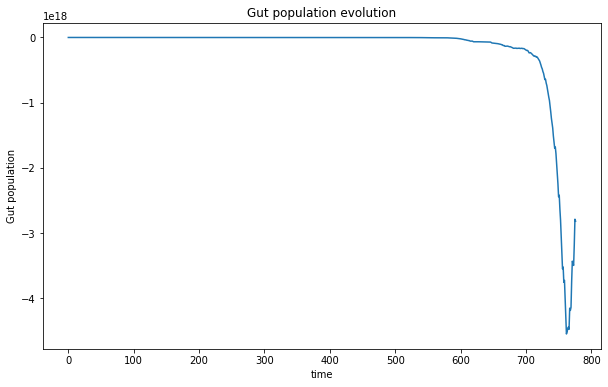

In [69]:

plt.figure(figsize = (10,6))                  #creating a new figure
plt.title("Gut population evolution")
plt.xlabel("time")          #labelling axes
plt.ylabel("Gut population")
# plt.ylim(0, 4000)
# plt.xlim(0, 1500)
plt.plot (populationDopamineHistory)
    

100.0